<img src='./img/logoline_12000.png' align='right' width='100%'></img>

<br>

# CMIP6: Global climate projections

### About

This notebook provides you a practical introduction to [CMIP6 global climate projections](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=overview). The workflow introduces you to four different experiments of CMIP6 Global climate projections: `historical`, `SSP 1-2.6`, `SSP 2-4.5`, `SSP 5-8.5`. The workflow shows you how to compute and visualize the annual global average temperature from 1850 to 2100. You will use the `historical` experiment for the temporal period 1850 to 2014 and the three scenarios `SSP1-2.6`, `SSP 2-4.5` and `SSP 5-8.5` for the period from 2015 to 2100. 


In general, CMIP6 experiments can be divided in two main categories:

**Historical**: Historical experiments cover the period where modern climate observations exist. These experiements show how the Global Circulation Model (GCM) perform for the past climate and can be used as reference period for comparison with scenario runs for the future. The period for the `historical` experiement is 1850-2005. 

**Projections**: climate projection experiments follow two pathways, a `Shared Socioeconomic Pathway (SSP)` and a `Representative Concentration Pathway (RCP)`. The two pathways are represented by the three digits that are part of the experiment's name. The first digit represent the SSP storyline for the socio-economic mitigation and adaptation challenges that the experiment represents. The second and third digit represent the RCP climate forcing that the experiment follows.
* **SSP 1-2.6**: SSP1-2.6 is based on SSP1 with low climate change mitigation and adaptation challenges and RCP2.6, a future pathway with a radiative forcing of 2.6 W/m2 in the year 2100. The SSP1-2.6 scenario represents the `low end of plausible future forcing pathways`. SSP1-2.6 depicts a "best case" future from a sustainability perspective.
* **SSP 2-4.5**: SSP2-4.5 is based on SSP2 with intermediate climate change mitigation and adaptation challenges and RCP4.5, a future pathway with a radiative forcing of 4.5 W/m2 in the year 2100. The ssp245 scenario represents the `medium part of plausible future forcing pathways`. SSP2-4.5 is comparable to the CMIP5 experiment RCP4.5.
* **SSP 5-8.5**: SSP5-8.5 is based on SSP5 in which climate change mitigation challenges dominate and RCP8.5, a future pathway with a radiative forcing of 8.5 W/m2 in the year 2100. The ssp585 scenario represents the `high end of plausible future forcing pathways`.  SSP5-8.5 is comparable to the CMIP5 experiment RCP8.5.

Learn [here](https://confluence.ecmwf.int/display/CKB/CMIP6%3A+Global+climate+projections#CMIP6:Globalclimateprojections-Experiments) more about CMIP6 experiments in the Copernicus Climate Data Store.


The notebook has the following outline:

* [1 - Unzip the downloaded data files](#unzip)
* [2 - Load and prepare CMIP6 historical data](#load_prepare_historical)
* [3 - Load and prepare CMIP6 Share Socioeconomic Pathway (SSP) scenarios](#load_prepare_ssp)
* [4 - Visualize CMIP6 annual global average temperature from 1850 to 2100](#visualize_cmip6)

### Data

This notebook introduces you to `CMIP6 Global climate projections`. The four datasets used in the notebook has the following specifications:

> **Data**: `CMIP6 Global climate projections - Experiment: Historical` <br>
> **Temporal coverage**: `Feb 1850 to Dec 2014` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `zip`<br>
> **Retrieve requests**: [CDS API request - CMIP6 Global climate projections - Experiment: Historical](./100_climate_data_store_intro.ipynb#cmip6_historical)

<br>

> **Data**: `CMIP6 Global climate projections - Experiment: SSP1-2.6` <br>
> **Temporal coverage**: `Jan 2015 - Dec 2100` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `zip`<br>
> **Retrieve request**: [CDS API request - CMIP6 Global climate projections - Experiment: SSP1-2.6](./100_climate_data_store_intro.ipynb#cmip6_ssp126)

<br>

> **Data**: `CMIP6 Global climate projections - Experiment: SSP2-4.5` <br>
> **Temporal coverage**: `Jan 2015 - Dec 2100` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `zip`<br>
> **Retrieve request**: [CDS API request - CMIP6 Global climate projections - Experiment: SSP2-4.5](./100_climate_data_store_intro.ipynb#cmip6_ssp245)

<br>

> **Data**: `CMIP6 Global climate projections - Experiment: SSP5-8.5` <br>
> **Temporal coverage**: `Jan 2015 - Dec 2100` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `zip`<br>
> **Retrieve request**: [CDS API request - CMIP6 Global climate projections - Experiment: SSP5-8.5](./100_climate_data_store_intro.ipynb#cmip6_ssp585)

<br>

Get [here](./101_c3s_data_intro.ipynb#climate_projections) more information about climate projections in general including an overview of the different dataset types available in the Copernicus Climate Data Store.

<hr>

### Load libraries

In [7]:
# CDS API
import cdsapi

#import cfgrib
# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

### Load helper functions

In [8]:
%run ./functions.ipynb

<hr>

## <a id='unzip'></a>1. Unzip the downloaded data files

The example below will show you how to calculate seasonal forecast anomalies of total precipitation for September 2021 and for five leadtime months (until February 2022). 
The term anomaly refers to the deviation of a value from the long-term average. A positive anomaly indicates that the average precipitation of this month was higher than the reference value, while a negative anomaly indicates that during this specific month, it rained less and it was drier than the reference value.

The first step is to calculate the hindcast climate mean for September, which is the longterm average of precipitation for seasonal forecasts with a start runtim in September and five lead time months (until February). The reference period for the seasonal hindcast data is from 1993 to 2016 and the hindcast climate mean represents the average conditions observed over this period. 

Seasonal forecast data are disseminated in the `GRIB` data format. You can use the Python library [xarray](http://xarray.pydata.org/en/stable/) and its function `open_dataset` to read GRIB files from ECMWF. To read a GRIB file, you have to specify the keyword argument `engine` and specify `'cfgrib'`. [cfgrib](https://github.com/ecmwf/cfgrib) is a Python interface to map GRIB files to the NetCDF Common Data Model using [ecCodes](https://github.com/ecmwf/eccodes).

The result is a `xarray.Dataset` object with five dimensions: `number`, `time`, `step`, `latitude` and `longitude`. 

In [1]:
import zipfile
with zipfile.ZipFile('./data/cmip6/1850-2019_historical_monthly.zip', 'r') as zip_ref:
    zip_ref.extractall('./data/cmip6/')

In [9]:
import zipfile
with zipfile.ZipFile('./data/cmip6/2015-2100_ssp1_2_6_monthly.zip', 'r') as zip_ref:
    zip_ref.extractall('./data/cmip6/')

In [10]:
import zipfile
with zipfile.ZipFile('./data/cmip6/2015-2100_ssp2_4_5_monthly.zip', 'r') as zip_ref:
    zip_ref.extractall('./data/cmip6/ssp245/')

In [11]:
import zipfile
with zipfile.ZipFile('./data/cmip6/2015-2100_ssp5_8_5_monthly.zip', 'r') as zip_ref:
    zip_ref.extractall('./data/cmip6/ssp585/')

<br>

## <a id='load_prepare_historical'></a>2. Load and prepare CMIP6 historical data

In [13]:
ds_historical = xr.open_dataset('./data/cmip6/historical/tas_Amon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_18500216-20141216_v20190624.nc')
ds_historical

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 144, lon: 192, time: 1979)
Coordinates:
  * time       (time) object 1850-02-16 00:00:00 ... 2014-12-16 00:00:00
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (time, lat, bnds) float64 ...
    lon_bnds   (time, lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-06-19T11:21:17Z
    ...                     ...
    title:                  HadGEM3-GC31-LL output prepared for CMIP6
    variable_id:            tas
    variant_label:          r1i1p1f3
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/b6959414-d5ed-4cd9-a627-59238e52132d

In [15]:
tas_historical = ds_historical['tas']
tas_historical

<xarray.DataArray 'tas' (time: 1979, lat: 144, lon: 192)>
[54715392 values with dtype=float32]
Coordinates:
  * time     (time) object 1850-02-16 00:00:00 ... 2014-12-16 00:00:00
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
    height   float64 1.5
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    original_name:  mo: (stash: m01s03i236, lbproc: 128)
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-06-19T11:21:17Z altered by CMOR: Treated scalar dime...

In [16]:
tas_historical_global = tas_historical.mean(['lat', 'lon'])
tas_historical_global

<xarray.DataArray 'tas' (time: 1979)>
array([274.7101 , 274.53793, 275.92035, ..., 278.79706, 278.2393 ,
       277.80856], dtype=float32)
Coordinates:
  * time     (time) object 1850-02-16 00:00:00 ... 2014-12-16 00:00:00
    height   float64 1.5

In [34]:
tas_historical_y1 = tas_historical_global.groupby('time.year').mean()
tas_historical_min = tas_historical_global.groupby('time.year').min()
tas_historical_max = tas_historical_global.groupby('time.year').max()



tas_historical_y1 = tas_historical_y1 - 273.15
tas_historical_y2 = tas_historical_min - 273.15
tas_historical_y3 = tas_historical_max - 273.15

tas_historical_y1, tas_historical_y2, tas_historical_y3

(<xarray.DataArray 'tas' (year: 165)>
 array([4.3600464, 4.0704346, 4.130005 , 4.071991 , 4.0331116, 4.124237 ,
        4.3029785, 4.381378 , 4.23468  , 4.21167  , 4.2608643, 4.239197 ,
        4.124176 , 4.1711426, 4.34317  , 4.3779907, 4.4490967, 4.384308 ,
        4.151764 , 4.1070557, 4.287964 , 4.1816406, 4.1411743, 3.944458 ,
        3.9414673, 4.0480957, 4.1900635, 4.168762 , 4.2135925, 4.1445007,
        4.2432556, 4.0849   , 4.085083 , 4.1128845, 3.970398 , 3.8516846,
        3.9885864, 4.0521545, 4.131256 , 4.065796 , 4.0144653, 4.145996 ,
        4.0554504, 4.0331116, 4.192932 , 3.9507446, 4.1132812, 4.113159 ,
        4.0354614, 4.138977 , 4.100952 , 4.0751953, 3.9570923, 3.8379517,
        4.0164795, 4.011688 , 3.9068298, 4.1728516, 4.105774 , 3.856018 ,
        3.6471252, 3.9300232, 3.7435913, 3.838379 , 4.197418 , 4.1291504,
        4.042877 , 4.1400146, 4.12381  , 4.2894287, 4.2493896, 4.188843 ,
        4.2125854, 4.3692017, 4.286682 , 4.1742554, 4.3094482, 4.140259 ,


<br>

## <a id='load_prepare_ssp'></a> 3. Load and prepare CMIP6 Shared Socioeconomic Pathway (SSP) scenarios

In [24]:
ds_ssp126 = xr.open_mfdataset('./data/cmip6/ssp126/*nc')
ds_ssp126

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 144, lon: 192, time: 1032)
Coordinates:
  * time       (time) object 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    height     float64 1.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(420, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(420, 144, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(420, 192, 2), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(420, 144, 192), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   59400.0
    branch_time_in_parent:  59400.0
    creation_date:          2020-01-13T10:05:17Z
    ...                     ...
    variable_id:            tas
    variable_name:          tas
    variant_label:          r1i1p1f3
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/b0278ac1-c92e-4847-9dc8-e75cbb8f30af

In [25]:
tas_ssp126 = ds_ssp126['tas']
tas_ssp126

<xarray.DataArray 'tas' (time: 1032, lat: 144, lon: 192)>
dask.array<concatenate, shape=(1032, 144, 192), dtype=float32, chunksize=(612, 144, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
    height   float64 1.5
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    original_name:  mo: (stash: m01s03i236, lbproc: 128)
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2020-01-13T10:05:17Z altered by CMOR: Treated scalar dime...

In [26]:
tas_ssp126_global = tas_ssp126.mean(['lat', 'lon'])
tas_ssp126_global

<xarray.DataArray 'tas' (time: 1032)>
dask.array<mean_agg-aggregate, shape=(1032,), dtype=float32, chunksize=(612,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
    height   float64 1.5

In [37]:
tas_ssp126_y1 = tas_ssp126_global.groupby('time.year').mean()
tas_ssp126_min = tas_ssp126_global.groupby('time.year').min()
tas_ssp126_max = tas_ssp126_global.groupby('time.year').max()



tas_ssp126_y1 = tas_ssp126_y1 - 273.15
tas_ssp126_y2 = tas_ssp126_min - 273.15
tas_ssp126_y3 = tas_ssp126_max - 273.15

tas_ssp126_y1, tas_ssp126_y2, tas_ssp126_y3

(<xarray.DataArray 'tas' (year: 86)>
 dask.array<sub, shape=(86,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
 Coordinates:
     height   float64 1.5
   * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100,
 <xarray.DataArray 'tas' (year: 86)>
 dask.array<sub, shape=(86,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
 Coordinates:
     height   float64 1.5
   * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100,
 <xarray.DataArray 'tas' (year: 86)>
 dask.array<sub, shape=(86,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
 Coordinates:
     height   float64 1.5
   * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100)

In [17]:
ds_ssp245 = xr.open_mfdataset('./data/cmip6/ssp245/*nc')
ds_ssp245

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 144, lon: 192, time: 1032)
Coordinates:
  * time       (time) object 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    height     float64 1.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(420, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(420, 144, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(420, 192, 2), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(420, 144, 192), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   59400.0
    branch_time_in_parent:  59400.0
    creation_date:          2019-09-06T15:31:59Z
    ...                     ...
    variable_id:            tas
    variable_name:          tas
    variant_label:          r1i1p1f3
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/9bf9e481-d3e7-415c-9a01-468753339a41

In [18]:
tas_ssp245 = ds_ssp245['tas']
tas_ssp245

<xarray.DataArray 'tas' (time: 1032, lat: 144, lon: 192)>
dask.array<concatenate, shape=(1032, 144, 192), dtype=float32, chunksize=(612, 144, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
    height   float64 1.5
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    original_name:  mo: (stash: m01s03i236, lbproc: 128)
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-09-06T15:31:59Z altered by CMOR: Treated scalar dime...

In [19]:
tas_ssp245_global = tas_ssp245.mean(['lat', 'lon'])
tas_ssp245_global

<xarray.DataArray 'tas' (time: 1032)>
dask.array<mean_agg-aggregate, shape=(1032,), dtype=float32, chunksize=(612,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
    height   float64 1.5

In [38]:
tas_ssp245_y1 = tas_ssp245_global.groupby('time.year').mean()
tas_ssp245_min = tas_ssp245_global.groupby('time.year').min()
tas_ssp245_max = tas_ssp245_global.groupby('time.year').max()



tas_ssp245_y1 = tas_ssp245_y1 - 273.15
tas_ssp245_y2 = tas_ssp245_min - 273.15
tas_ssp245_y3 = tas_ssp245_max - 273.15

tas_ssp245_y1, tas_ssp245_y2, tas_ssp245_y3

(<xarray.DataArray 'tas' (year: 86)>
 dask.array<sub, shape=(86,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
 Coordinates:
     height   float64 1.5
   * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100,
 <xarray.DataArray 'tas' (year: 86)>
 dask.array<sub, shape=(86,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
 Coordinates:
     height   float64 1.5
   * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100,
 <xarray.DataArray 'tas' (year: 86)>
 dask.array<sub, shape=(86,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
 Coordinates:
     height   float64 1.5
   * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100)

<br>

In [20]:
ds_ssp585 = xr.open_mfdataset('./data/cmip6/ssp585/*nc')
ds_ssp585

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 144, lon: 192, time: 1032)
Coordinates:
  * time       (time) object 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    height     float64 1.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(420, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(420, 144, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(420, 192, 2), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(420, 144, 192), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   59400.0
    branch_time_in_parent:  59400.0
    creation_date:          2020-01-13T08:51:11Z
    ...                     ...
    variable_id:            tas
    variable_name:          tas
    variant_label:          r1i1p1f3
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/bd489bc6-c257-4eb2-9a69-568d0a2c2eb0

In [21]:
tas_ssp585 = ds_ssp585['tas']
tas_ssp585

<xarray.DataArray 'tas' (time: 1032, lat: 144, lon: 192)>
dask.array<concatenate, shape=(1032, 144, 192), dtype=float32, chunksize=(612, 144, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
    height   float64 1.5
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    original_name:  mo: (stash: m01s03i236, lbproc: 128)
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2020-01-13T08:51:11Z altered by CMOR: Treated scalar dime...

In [22]:
tas_ssp585_global = tas_ssp585.mean(['lat', 'lon'])
tas_ssp585_global

<xarray.DataArray 'tas' (time: 1032)>
dask.array<mean_agg-aggregate, shape=(1032,), dtype=float32, chunksize=(612,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
    height   float64 1.5

In [39]:
tas_ssp585_y1 = tas_ssp585_global.groupby('time.year').mean()
tas_ssp585_min = tas_ssp585_global.groupby('time.year').min()
tas_ssp585_max = tas_ssp585_global.groupby('time.year').max()



tas_ssp585_y1 = tas_ssp585_y1 - 273.15
tas_ssp585_y2 = tas_ssp585_min - 273.15
tas_ssp585_y3 = tas_ssp585_max - 273.15

tas_ssp585_y1, tas_ssp585_y2, tas_ssp585_y3

(<xarray.DataArray 'tas' (year: 86)>
 dask.array<sub, shape=(86,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
 Coordinates:
     height   float64 1.5
   * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100,
 <xarray.DataArray 'tas' (year: 86)>
 dask.array<sub, shape=(86,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
 Coordinates:
     height   float64 1.5
   * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100,
 <xarray.DataArray 'tas' (year: 86)>
 dask.array<sub, shape=(86,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
 Coordinates:
     height   float64 1.5
   * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100)

<br>

## <a id='visualize_cmip6'></a>4. Visualize the CMIP6 annual global average temperature from 1850 to 2100

(array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

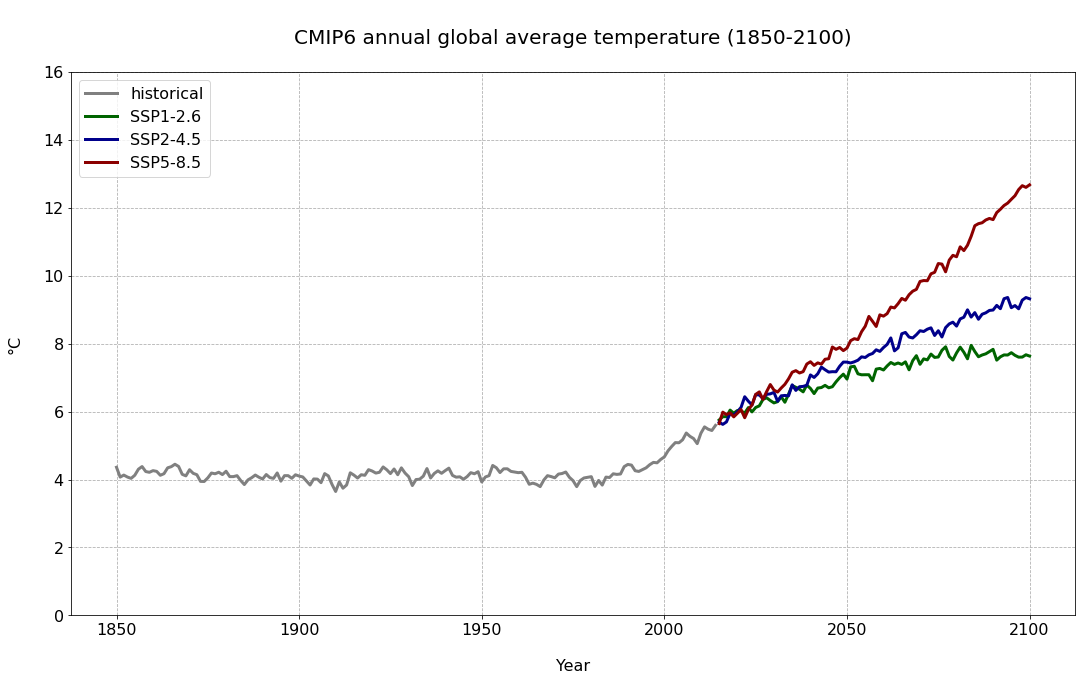

In [60]:
# Initiate the plot
fig = plt.figure(figsize=(18,10))
ax = plt.subplot()

# Plot mean maximum temperature time-series and +/- sd as filled range
ax.plot(tas_historical_y1.year[:], tas_historical_y1, color='grey', linewidth='3', label='historical')
#ax.fill_between(tas_historical_y1.year[:], tas_historical_y2, tas_historical_y3, alpha=0.1, color='grey', label='historical')
#ax.plot(era5_t2m_daily_max_lille.day[:-1], y_2020, 'bo-', color='grey')

ax.plot(tas_ssp126_y1.year[:], tas_ssp126_y1, color='darkgreen', linewidth='3', label='SSP1-2.6')
#ax.fill_between(tas_ssp126_y1.year[:], tas_ssp126_y2, tas_ssp126_y3, alpha=0.1, color='green', label='SSP1-2.6')

ax.plot(tas_ssp245_y1.year[:], tas_ssp245_y1, color='darkblue', linewidth='3', label='SSP2-4.5')
#ax.fill_between(tas_ssp245_y1.year[:], tas_ssp245_y2, tas_ssp245_y3, alpha=0.1, color='blue', label='SSP2-4.5')

ax.plot(tas_ssp585_y1.year[:], tas_ssp585_y1, color='darkred', linewidth='3', label='SSP5-8.5')
#ax.fill_between(tas_ssp585_y1.year[:], tas_ssp585_y2, tas_ssp585_y3, alpha=0.1, color='red', label='SSP5-8.5')

# Set axes labels and titles and customize legend
ax.set_title('\nCMIP6 annual global average temperature (1850-2100)\n', fontsize=20)
ax.set_ylabel('°C\n', fontsize=16)
ax.set_xlabel('\nYear', fontsize=16)
plt.legend(fontsize=16, loc=2)

# Customize limits for y-axis, grid and fontsize of x- and y-tickes
ax.set_ylim(0,14)
ax.grid(linestyle='--')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

<br>

<hr>

<p><img src='./img/copernicus_logo.png' align='right' alt='Logo EU Copernicus' width='20%'></img></p>
<br><br><br><br><br>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>